<a href="https://colab.research.google.com/github/hida0/ESAA-2022-2/blob/Project/Project_Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 구글 드라이브 어마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **라이브러리 임포트**

In [13]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import io

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm, skew

In [ ]:
!pip install category_encoders
!pip install catboost

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score, learning_curve
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier  
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, f1_score, log_loss
from tensorflow.keras.utils import to_categorical
from xgboost import plot_importance

#### **데이터 로드**

In [119]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [7]:
print(train.shape)
train.head()

(26457, 20)


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [8]:
print(test.shape)
test.head()

(10000, 19)


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


### **데이터 시각화 및 1차 전처리 진행**

#### **불필요한 변수 제거 - index, FLAG_MOBIL은 전부 다 1이라서 제거**

In [120]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

#### **결측치 확인**

In [10]:
train.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

> **occyp_type 변수만 결측치가 존재**

#### **family_type**

In [11]:
train['family_type'].value_counts()

Married                 18196
Single / not married     3496
Civil marriage           2123
Separated                1539
Widow                    1103
Name: family_type, dtype: int64

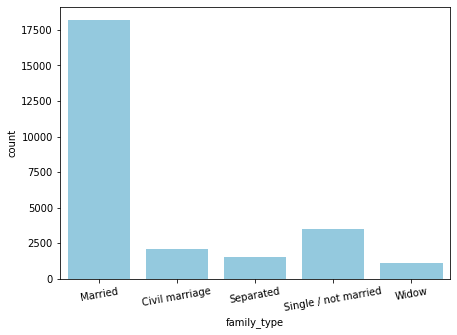

In [14]:
ax = plt.figure(figsize=(7,5))
ax = sns.countplot(x='family_type', data=train, color='skyblue')
plt.xticks(rotation=10)
plt.show()

#### **occyp_type** 
> **8171개의 NaN 존재**

In [15]:
train['occyp_type'].value_counts()

Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

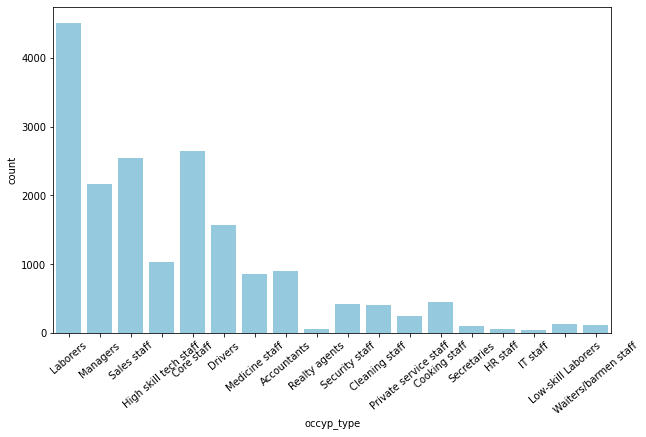

In [17]:
ax = plt.figure(figsize=(10, 6))
ax = sns.countplot(x='occyp_type', data=train, color='skyblue') 
plt.xticks(rotation=40)
plt.show()

> **결측치를 'etc'로 대체**

In [121]:
train['occyp_type'].fillna('etc', inplace = True)
test['occyp_type'].fillna('etc', inplace = True)

#### **gender**

In [19]:
train['gender'].value_counts()

F    17697
M     8760
Name: gender, dtype: int64

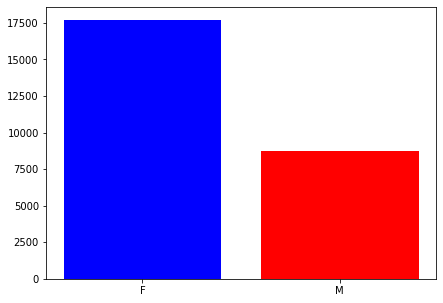

In [20]:
t = train.gender.value_counts()
plt.figure(figsize=(7, 5))
plt.bar(t.index, t.values, color=['blue', 'red'])
plt.show()

> **남녀의  차이가 2배 이상**

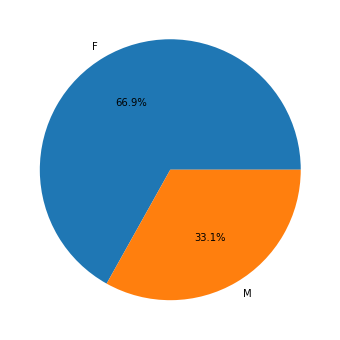

In [21]:
plt.figure(figsize=(6, 6))
plt.pie(t.values, labels=t.index, autopct='%1.1f%%')
plt.show()

#### **income_total**

(2000.0, 600000.0)

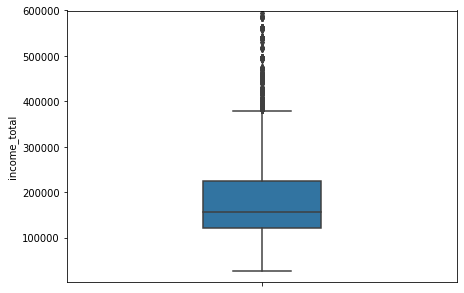

In [22]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=train,y="income_total", width=0.3)
plt.ylim(2000, 600000)

In [23]:
np.min(train['income_total'])

27000.0

In [24]:
np.max(train['income_total'])

1575000.0

> **IQR 밖의 이상치 확인**

In [25]:
df = train['income_total']
quan_25 = np.percentile(df.values, 25)
quan_75 = np.percentile(df.values, 75)
iqr = quan_75 - quan_25
lowest = quan_25 - iqr * 5
highest = quan_75 + iqr * 5
outlier_index = df[(df < lowest) | (df > highest)].index
print('outlier의 수 : ' , len(outlier_index))

outlier의 수 :  68



 mu = 187306.52 and sigma = 101876.44



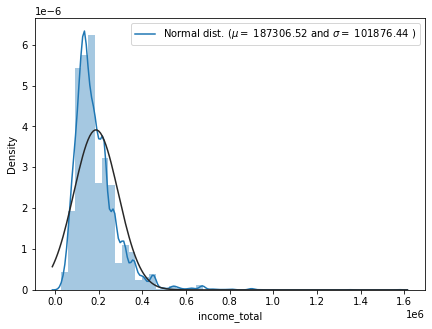

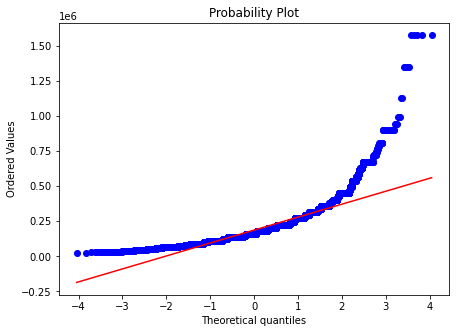

In [27]:
plt.figure(figsize=(7, 5))
sns.distplot(train['income_total'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['income_total'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
# plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

# Get also the QQ-plot
fig = plt.figure(figsize=(7, 5))
res = stats.probplot(train['income_total'], plot=plt)
plt.show()

> **로그 변환**

In [122]:
# 파생변수 생성을 위해 원본 값 복사본 생성
train['income_total_copy'] = train["income_total"]
test['income_total_copy'] = test["income_total"]

In [123]:
train["income_total"] = np.log1p(train["income_total"])
test["income_total"] = np.log1p(test["income_total"])


 mu = 12.02 and sigma = 0.48



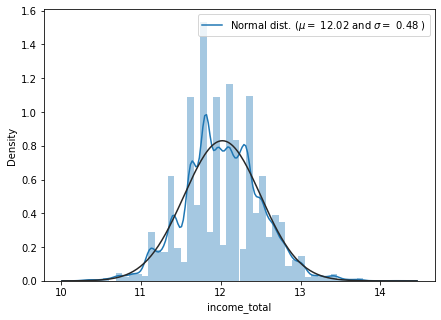

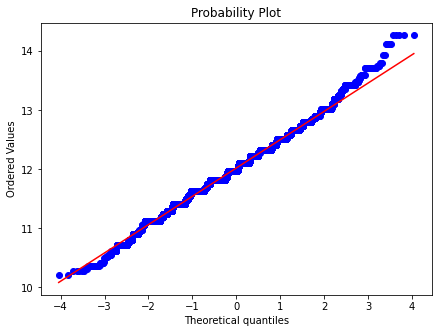

In [30]:
plt.figure(figsize=(7, 5))
sns.distplot(train['income_total'], fit=norm)

# Get the fitted parpameters used by the function
(mu, sigma) = norm.fit(train['income_total'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
# plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')

# Get QQ-plot
fig = plt.figure(figsize=(7, 5))
res = stats.probplot(train['income_total'], plot=plt)
plt.show()

> **로그 변환 후 이상치 사라짐**

In [32]:
df = train['income_total']
quan_25 = np.percentile(df.values, 25)
quan_75 = np.percentile(df.values, 75)
iqr = quan_75 - quan_25
lowest = quan_25 - iqr * 5
highest = quan_75 + iqr * 5
outlier_index = df[(df < lowest) | (df > highest)].index
print('outlier의 수 : ' , len(outlier_index))

outlier의 수 :  0


#### **house_type**

In [31]:
train['house_type'].value_counts()

House / apartment      23653
With parents            1257
Municipal apartment      818
Rented apartment         429
Office apartment         190
Co-op apartment          110
Name: house_type, dtype: int64

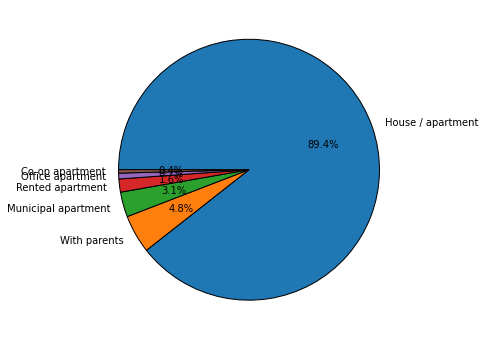

In [33]:
t = train.house_type.value_counts()
explode = (0.1, 0.1)
fig = plt.figure(figsize=(6, 6))
fig.set_facecolor('white')
plt.pie(t, labels=t.index, startangle=180, autopct='%1.1f%%', counterclock=False, wedgeprops = {'edgecolor':'k','linestyle':'-','linewidth':1})
plt.show()

#### **work_phone**

In [34]:
train['work_phone'].value_counts()

0    20511
1     5946
Name: work_phone, dtype: int64

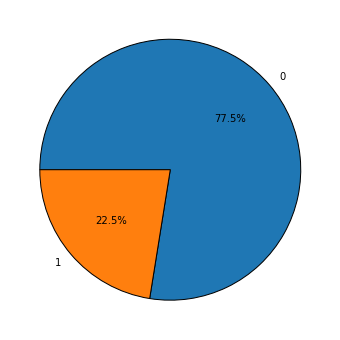

In [35]:
t = train.work_phone.value_counts()
explode = (0.1, 0.1)
fig = plt.figure(figsize=(6, 6)) 
fig.set_facecolor('white')
plt.pie(t, labels=t.index, startangle=180, autopct='%1.1f%%', counterclock=False, wedgeprops = {'edgecolor':'k','linestyle':'-','linewidth':1})
plt.show()

#### **reality**

In [36]:
train['reality'].value_counts()

Y    17830
N     8627
Name: reality, dtype: int64

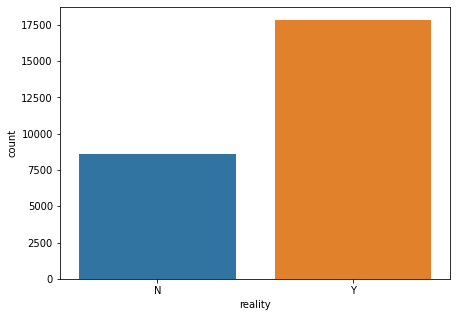

In [37]:
plt.figure(figsize=(7, 5))
sns.countplot(data=train, x='reality')
plt.show()

#### **edu_type**

In [38]:
train['edu_type'].value_counts()

Secondary / secondary special    17995
Higher education                  7162
Incomplete higher                 1020
Lower secondary                    257
Academic degree                     23
Name: edu_type, dtype: int64

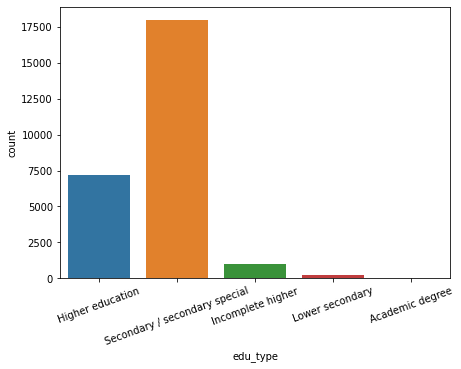

In [39]:
plt.figure(figsize=(7, 5))
sns.countplot(data=train, x = 'edu_type')
plt.xticks(rotation=20)
plt.show()

#### **DAYS_EMPLOYED**

In [40]:
min(train['DAYS_EMPLOYED'])

-15713

In [41]:
max(train['DAYS_EMPLOYED'])

365243

In [42]:
(train['DAYS_EMPLOYED']> 0).sum()

4438

> **양수값은 0으로 처리**

In [124]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

> **음수값을 양수값으로 처리** 

In [125]:
train['DAYS_EMPLOYED'] = np.abs(train['DAYS_EMPLOYED'])
test['DAYS_EMPLOYED'] = np.abs(train['DAYS_EMPLOYED'])

In [126]:
min(train['DAYS_EMPLOYED'])

0

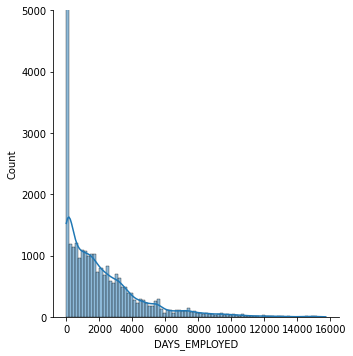

In [46]:
sns.displot(train['DAYS_EMPLOYED'], kde=True, rug=False)
plt.ylim(0, 5000)
plt.show()

> **고용일을 이용하여 연/월/주 단위의 새로운 변수로 생성**

In [127]:
# 연 단위
train['YEARS_EMPLOYED'] = train['DAYS_EMPLOYED'] // 365
test['YEARS_EMPLOYED'] = train['DAYS_EMPLOYED'] // 365

In [128]:
# 월 단위
train['MONTHS_EMPLOYED'] = np.floor(train['DAYS_EMPLOYED'] / 30) - ((np.floor(train['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
test['MONTHS_EMPLOYED'] = np.floor(test['DAYS_EMPLOYED'] / 30) - ((np.floor(test['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)

In [129]:
# 주 단위
train['WEEKS_EMPLOYED'] = np.floor(train['DAYS_EMPLOYED'] / 7) - ((np.floor(train['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)
test['WEEKS_EMPLOYED'] = np.floor(test['DAYS_EMPLOYED'] / 7) - ((np.floor(test['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

#### **email**
> **0이 1의 10배 가까이 됨**

In [50]:
train['email'].value_counts()

0    24042
1     2415
Name: email, dtype: int64

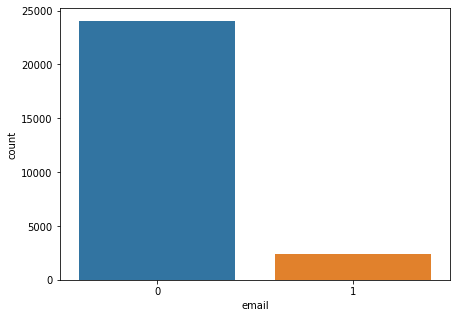

In [51]:
plt.figure(figsize=(7, 5))
sns.countplot(data=train, x = 'email')
plt.show()

#### **car**

In [56]:
train['car'].value_counts()

N    16410
Y    10047
Name: car, dtype: int64

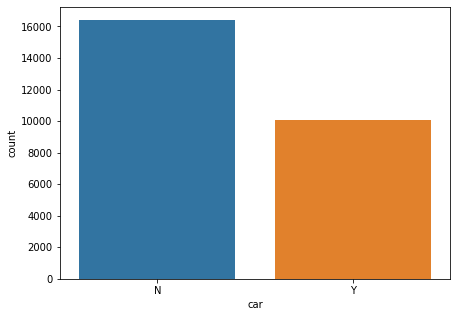

In [57]:
plt.figure(figsize=(7, 5))
sns.countplot(data=train, x = 'car')
plt.show()

#### **income_type**

In [58]:
train['income_type'].value_counts()

Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64

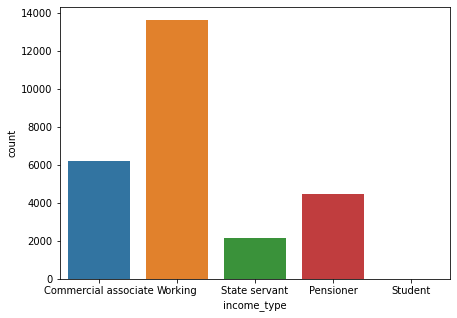

In [59]:
plt.figure(figsize=(7, 5))
sns.countplot(data=train, x = 'income_type')
plt.show()

#### **DAYS_BIRTH**
> **음수값을 양수값으로 처리**

In [130]:
train['DAYS_BIRTH'] = np.abs(train['DAYS_BIRTH'])
test['DAYS_BIRTH'] = np.abs(test['DAYS_BIRTH'])

In [131]:
(train['DAYS_BIRTH'] >= 0).sum()

26457

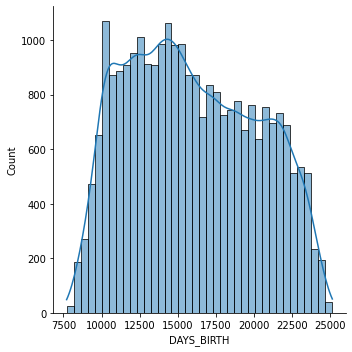

In [65]:
sns.displot(train['DAYS_BIRTH'], kde=True, rug=False)
plt.show()

In [66]:
np.min(train['DAYS_BIRTH'])

7705

In [67]:
np.max(train['DAYS_BIRTH'])

25152

#### **phone**

In [68]:
train['phone'].value_counts()

0    18672
1     7785
Name: phone, dtype: int64

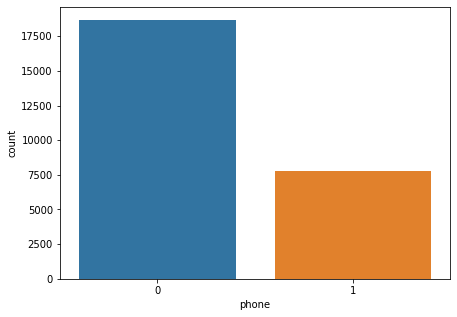

In [69]:
plt.figure(figsize=(7, 5))
sns.countplot(data=train, x = 'phone')
plt.show()

#### **begin_month**
> **0인 231개의 자료는 신용카드를 발급받지 않았거나, 발급받은지 한달이 지나지 않았다고 해석**

In [132]:
(train['begin_month'] == 0).sum()

231

> **음수값을 양수값으로 처리**

In [134]:
train['begin_month'] = np.abs(train['begin_month'])
test['begin_month'] = np.abs(test['begin_month'])

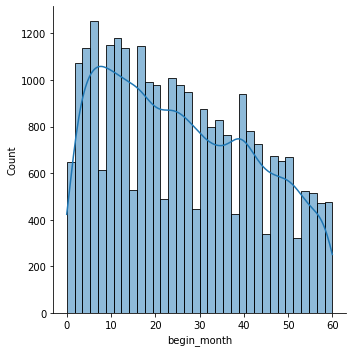

In [135]:
sns.displot(train['begin_month'], kde=True, rug=False)
plt.show()

In [74]:
np.min(train['begin_month'])

0.0

In [75]:
np.max(train['begin_month'])

60.0

#### **child_num**

In [76]:
train['child_num'].describe()

count    26457.000000
mean         0.428658
std          0.747326
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: child_num, dtype: float64

> **max가 19로 평균과 차이가 많이 나므로 이상치가 존재한다고 판단**

In [77]:
train['child_num'].value_counts()

0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64

> **7 이상의 값은 이상치라고 판단하여 최빈값 0으로 처리**

In [136]:
train[train['child_num']>=7]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,phone,email,occyp_type,family_size,begin_month,credit,income_total_copy,YEARS_EMPLOYED,MONTHS_EMPLOYED,WEEKS_EMPLOYED
8462,M,Y,Y,14,12.323860,Working,Secondary / secondary special,Separated,House / apartment,17754,...,0,0,Drivers,15.0,7.0,2.0,225000.0,4,8.0,1.0
9021,M,Y,Y,14,12.323860,Working,Secondary / secondary special,Separated,House / apartment,17754,...,0,0,Drivers,15.0,58.0,2.0,225000.0,4,8.0,1.0
10731,F,N,Y,19,11.630717,Working,Secondary / secondary special,Single / not married,House / apartment,11057,...,1,0,Waiters/barmen staff,20.0,5.0,2.0,112500.0,5,1.0,0.0
25313,F,N,N,7,11.967187,Working,Secondary / secondary special,Married,House / apartment,13827,...,1,0,Cleaning staff,9.0,26.0,2.0,157500.0,4,6.0,3.0
25390,M,Y,Y,14,12.323860,Working,Secondary / secondary special,Separated,House / apartment,17754,...,0,0,Drivers,15.0,43.0,2.0,225000.0,4,8.0,1.0
25638,F,N,N,7,11.967187,Working,Secondary / secondary special,Married,House / apartment,13827,...,1,0,Cleaning staff,9.0,31.0,2.0,157500.0,4,6.0,3.0


In [137]:
train.loc[(train['child_num']>=7), 'child_num'] = 0 

In [138]:
train[train['child_num']>=7]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,phone,email,occyp_type,family_size,begin_month,credit,income_total_copy,YEARS_EMPLOYED,MONTHS_EMPLOYED,WEEKS_EMPLOYED


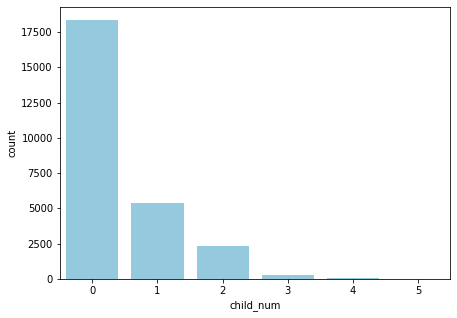

In [100]:
ax = plt.figure(figsize=(7, 5))
ax = sns.countplot(x='child_num', data=train, color='skyblue')
plt.show()

#### **family_size**

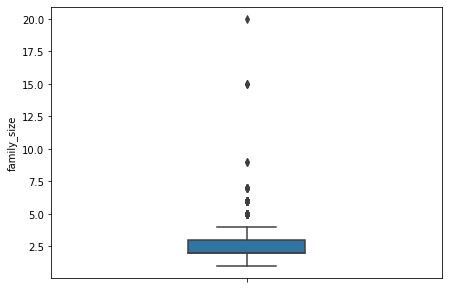

In [80]:
ax = plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=train,y="family_size", width=0.3)
plt.show()

> **IQR 밖의 이상치 확인**

In [141]:
df = train['family_size']
quan_25 = np.percentile(df.values, 25)
quan_75 = np.percentile(df.values, 75)
iqr = quan_75 - quan_25
lowest = quan_25 - iqr * 5
highest = quan_75 + iqr * 5
outlier_index = df[(df < lowest) | (df > highest)].index
print('outlier의 수 : ' , len(outlier_index))

outlier의 수 :  6


> **이상치를 최빈값 2.0으로 처리**

In [142]:
train.loc[outlier_index, 'family_size'] = 2.0

In [143]:
df = train['family_size']
quan_25 = np.percentile(df.values, 25)
quan_75 = np.percentile(df.values, 75)
iqr = quan_75 - quan_25
lowest = quan_25 - iqr * 5
highest = quan_75 + iqr * 5
outlier_index = df[(df < lowest) | (df > highest)].index
print('outlier의 수 : ' , len(outlier_index))

outlier의 수 :  0


#### **credit(Target variable)**
> **float64형이지만 범주형 타겟값에 해당**

In [54]:
train['credit'].value_counts()

2.0    16968
1.0     6267
0.0     3222
Name: credit, dtype: int64

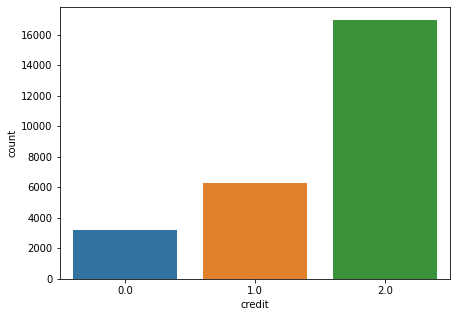

In [55]:
plt.figure(figsize=(7, 5))
sns.countplot(data=train, x = 'credit')
plt.show()

#### **상관관계 확인**


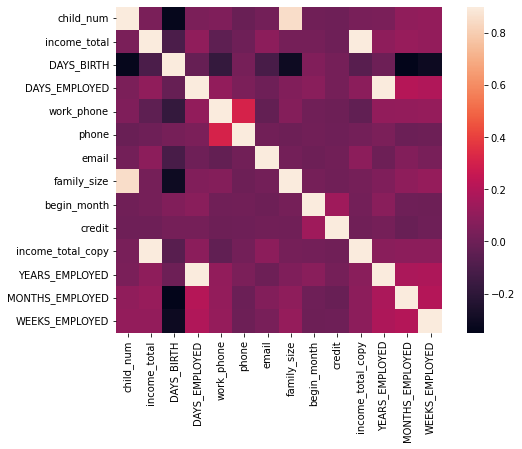

In [85]:
corrmat = train.corr()
plt.subplots(figsize=(9, 6))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

In [86]:
corrmat

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit,income_total_copy,YEARS_EMPLOYED,MONTHS_EMPLOYED,WEEKS_EMPLOYED
child_num,1.000000,0.036812,-0.332816,0.043122,0.051521,-0.010555,0.016120,0.855324,0.007229,0.004081,0.032186,0.037123,0.100962,0.111031
income_total,0.036812,1.000000,-0.105269,0.101048,-0.046067,0.001468,0.091717,0.023033,0.023768,0.005539,0.921367,0.095309,0.120640,0.108988
DAYS_BIRTH,-0.332816,-0.105269,1.000000,-0.020244,-0.178752,0.029247,-0.111238,-0.303860,0.057306,0.025187,-0.064155,-0.002725,-0.350569,-0.307182
DAYS_EMPLOYED,0.043122,0.101048,-0.020244,1.000000,0.108538,0.041886,0.002904,0.057421,0.082669,0.022824,0.086899,0.998838,0.209883,0.195328
work_phone,0.051521,-0.046067,-0.178752,0.108538,1.000000,0.310256,-0.031048,0.068524,0.008563,-0.003134,-0.034207,0.104368,0.110995,0.115761
phone,-0.010555,0.001468,0.029247,0.041886,0.310256,1.000000,0.012494,-0.001161,0.014286,0.003452,0.019013,0.041923,-0.005529,-0.000074
email,0.016120,0.091717,-0.111238,0.002904,-0.031048,0.012494,1.000000,0.017406,-0.002320,0.014812,0.089882,0.000268,0.061617,0.032948
family_size,0.855324,0.023033,-0.303860,0.057421,0.068524,-0.001161,0.017406,1.000000,0.023416,0.006355,0.024459,0.051432,0.095277,0.114493
begin_month,0.007229,0.023768,0.057306,0.082669,0.008563,0.014286,-0.002320,0.023416,1.000000,0.147477,0.018047,0.083334,0.002491,-0.003576
credit,0.004081,0.005539,0.025187,0.022824,-0.003134,0.003452,0.014812,0.006355,0.147477,1.000000,0.008555,0.023844,-0.014372,0.002108


### **1차 전처리 후 변수 확인**
> **train data와 test data의 모든 변수에 결측치 존재하지 않음**

In [87]:
train.isnull().sum()

gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
work_phone           0
phone                0
email                0
occyp_type           0
family_size          0
begin_month          0
credit               0
income_total_copy    0
YEARS_EMPLOYED       0
MONTHS_EMPLOYED      0
WEEKS_EMPLOYED       0
dtype: int64

In [89]:
test.isnull().sum()

gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
work_phone           0
phone                0
email                0
occyp_type           0
family_size          0
begin_month          0
income_total_copy    0
YEARS_EMPLOYED       0
MONTHS_EMPLOYED      0
WEEKS_EMPLOYED       0
dtype: int64

### **1차 전처리 데이터셋 저장** -> 따로 안해도 되겠지?

In [ ]:
train.to_csv("/content/drive/MyDrive/ESAA 2학기 /프로젝트(1)/데이터/train_preprocessing1.csv", index = False)
test.to_csv("/content/drive/MyDrive/ESAA 2학기 /프로젝트(1)/데이터/test_preprocessing1.csv", index = False)

### **2차 전처리 진행**




#### **1. 새로운 age 변수 생성**
> **DAYS_BIRTH를 365로 나눠서 나이를 의미하는 변수 age 생성**

In [144]:
train['age'] = train['DAYS_BIRTH'] // 365
test['age'] = test['DAYS_BIRTH'] // 365

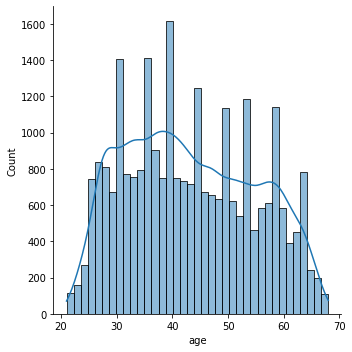

In [145]:
sns.displot(train['age'], kde=True, rug=False)
plt.show()

#### **2. 가족 수 별 소득 per_income 생성**
> **로그 변환 전의 Income_total을 family_size로 나눠서 가족 수 별 소득을 의미하는 변수 per_income** 생성

In [146]:
train['per_income'] = train['income_total_copy'] / train['family_size']
test['per_income'] = test['income_total_copy'] / test['family_size']

> **새롭게 생성한 per_income 변수에 로그 변환 적용**

In [147]:
train['per_income'] = round(np.log1p(train['per_income']), 2)
test['per_income'] = round(np.log1p(test['per_income']), 2)

#### **3. 취업 나이 파생 변수 생성**
> **DAYS_EMPLOYED 변수를 365로 나눠서 고용 연차를 의미하는 변수 year_work 생성**

In [148]:
train['year_work'] = train['DAYS_EMPLOYED'] // 365
test['year_work'] = test['DAYS_EMPLOYED'] // 365

> **'age-year_work'로 나이에서 고용 연차를 빼서 취업 나이를 나타내는 새로운 변수 age_work 생성**

In [149]:
train['age_work'] = train['age'] - train['year_work']
test['age_work'] = test['age'] - test['year_work']

> **새로운 변수 age_work 생성 후에는 고용 연차 변수 year_work는 제거**

In [150]:
train.drop('year_work', axis=1, inplace=True)
test.drop('year_work', axis=1, inplace=True)

#### **4. 범주형 변수 라벨 인코딩**

> **모델 학습을 위해 2차 전처리를 마친 데이터를 복사하여 범주형 변수에 대해 라벨 인코딩을 진행**

In [116]:
train2 = train.copy()
test2 = test.copy()

In [151]:
train2['gender'] = train2['gender'].replace(['F','M'], [0,1])
test2['gender'] = test2['gender'].replace(['F','M'], [0,1])

train2['car'] = train2['car'].replace(['N','Y'], [0,1])
test2['car'] = test2['car'].replace(['N','Y'], [0,1])

train2['reality'] = train2['reality'].replace(['N','Y'], [0,1])
test2['reality'] = test['reality'].replace(['N','Y'], [0,1])

In [153]:
train2.dtypes

gender                 int64
car                    int64
reality                int64
child_num              int64
income_total         float64
income_type           object
edu_type              object
family_type           object
house_type            object
DAYS_BIRTH             int64
DAYS_EMPLOYED          int64
work_phone             int64
phone                  int64
email                  int64
occyp_type            object
family_size          float64
begin_month          float64
credit               float64
income_total_copy    float64
YEARS_EMPLOYED         int64
MONTHS_EMPLOYED      float64
WEEKS_EMPLOYED       float64
age                    int64
per_income           float64
age_work               int64
dtype: object

In [156]:
from category_encoders.ordinal import OrdinalEncoder

cate_list = ['income_type', 'edu_type', 'house_type', 'family_type', 'occyp_type']

encoder = OrdinalEncoder(cate_list)
train2[cate_list] = encoder.fit_transform(train2[cate_list])
test2[cate_list] = encoder.fit_transform(test2[cate_list])

> **object형 변수 사라짐**

In [157]:
train2.dtypes

gender                 int64
car                    int64
reality                int64
child_num              int64
income_total         float64
income_type            int64
edu_type               int64
family_type            int64
house_type             int64
DAYS_BIRTH             int64
DAYS_EMPLOYED          int64
work_phone             int64
phone                  int64
email                  int64
occyp_type             int64
family_size          float64
begin_month          float64
credit               float64
income_total_copy    float64
YEARS_EMPLOYED         int64
MONTHS_EMPLOYED      float64
WEEKS_EMPLOYED       float64
age                    int64
per_income           float64
age_work               int64
dtype: object

> **2차 전처리 완료**

### **2차 전처리 후 데이터셋 저장**

In [158]:
train2.to_csv('/content/train_after2.csv', index=False)
test2.to_csv('/content/test_after2.csv', index=False)

### **1차 모델링**

> **모델 학습 전 데이터 분할**

In [159]:
train_x = train2.drop('credit', axis=1)
train_y = train2['credit']
test_x = test2

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.25, random_state=100)

> **교차 검증 함수 정의**

In [112]:
def run_kfold(clf):
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes = []
    sub = np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions = clf.predict_proba(X_val)
        
        logloss = log_loss(to_categorical(y_val), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub += clf.predict_proba(test_x)
        
    mean_outcome = np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

> **학습 곡선 함수 정의**

In [113]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1,1.0,5)):
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel("Training examples")
  plt.ylabel("Score")
  train_sizes, train_scores, test_scores = learning_curve(
      estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
  )
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  # 그래프 사이의 공간 색칠
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.1, color='r')
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, alpha=0.1, color='r')
  plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label = "Training score")
  plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label = "Cross-validation score")
  plt.legend(loc='best')
  return plt

> **피처 중요도 함수 정의**

In [114]:
def plot_feature_importance(importance, names, model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.show()

### **1. LGBM**

> **Grid Search 진행**

In [160]:
params = {'num_leaves': [32, 64],
          'max_depth': [4,6,8,10,12],
          'min_child_samples': [60,100],
          'subsample': [0.8,1]}

lgbm_clf = LGBMClassifier()
grid_search = GridSearchCV(lgbm_clf, params)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'max_depth': [4, 6, 8, 10, 12],
                         'min_child_samples': [60, 100], 'num_leaves': [32, 64],
                         'subsample': [0.8, 1]})

In [161]:
grid_search.best_params_

{'max_depth': 12, 'min_child_samples': 60, 'num_leaves': 64, 'subsample': 0.8}

> **최적 하이퍼 파라미터로 모델 학습과 예측**

In [162]:
lgbm_clf = LGBMClassifier(n_estimators=200, learning_rate=0.05, num_iterations=50,  max_depth=12, num_leaves=64, min_child_samples=60, subsample=0.8)

In [163]:
lgbm2_submission = run_kfold(lgbm_clf)

FOLD 0 : logloss:0.7856453054614442
FOLD 1 : logloss:0.7770337714467205
FOLD 2 : logloss:0.7827168518511445
FOLD 3 : logloss:0.7792602632018845
FOLD 4 : logloss:0.7782827971353823
Mean:0.7805877978193152


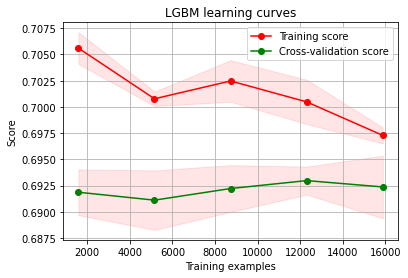

In [164]:
g = plot_learning_curve(lgbm_clf, "LGBM learning curves", X_train, y_train, cv=5)

> **제출 파일 생성**

In [165]:
submission_lgbm2 = pd.read_csv('/content/sample_submission.csv')
submission_lgbm2.loc[:,1:] = lgbm2_submission

In [167]:
submission_lgbm2.to_csv('/content/sub_lgbm2.csv', index=False)

### **2. Random Forest**

> **Grid Search 진행**

In [169]:
param_grid = { 'criterion' : ['gini', 'entropy', 'log_loss'],
              'max_depth' : [6,8,10,12],
              'min_samples_leaf' : [8,12,18],
              'min_samples_split' : [8,16,20]}

rnd_clf = RandomForestClassifier()
grid_search = GridSearchCV(rnd_clf, param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [6, 8, 10, 12],
                         'min_samples_leaf': [8, 12, 18],
                         'min_samples_split': [8, 16, 20]})

In [170]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 12,
 'min_samples_leaf': 8,
 'min_samples_split': 8}

> **최적 하이퍼 파라미터로 모델 학습과 예측**

In [171]:
rnd_clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=12, min_samples_leaf=8, min_samples_split=8)

In [172]:
rnd2_submission = run_kfold(rnd_clf)

FOLD 0 : logloss:0.7737570135165598
FOLD 1 : logloss:0.769405081256438
FOLD 2 : logloss:0.7729039447707229
FOLD 3 : logloss:0.7720780592642755
FOLD 4 : logloss:0.7708974549870332
Mean:0.7718083107590059


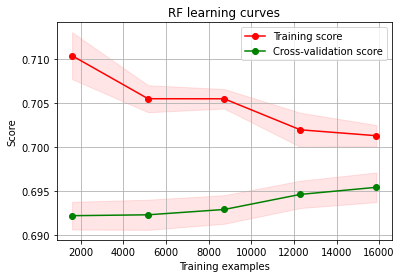

In [173]:
g = plot_learning_curve(rnd_clf, "RF learning curves", X_train, y_train, cv=5)

> **제출 파일 생성**

In [174]:
submission_rnd2 = pd.read_csv('/content/sample_submission.csv')
submission_rnd2.loc[:,1:] = rnd2_submission

In [175]:
submission_rnd2.to_csv('/content/sub_rnd2.csv', index=False)

### **3. XGBoost**

> **Grid Search 진행**

In [176]:
param_grid = {'n_estimators' : [70, 80, 90, 100],
              'learning_rate' : [0.05, 0.1, 0.15, 0.2],
              'max_depth': [4,6,8,10,12]}
              
xgb = XGBClassifier()
grid_search_xgb = GridSearchCV(xgb, param_grid, cv=3, scoring='neg_log_loss')
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2],
                         'max_depth': [4, 6, 8, 10, 12],
                         'n_estimators': [70, 80, 90, 100]},
             scoring='neg_log_loss')

In [177]:
grid_search_xgb.best_params_

{'learning_rate': 0.15, 'max_depth': 10, 'n_estimators': 70}

> **최적 하이퍼 파라미터로 모델 학습과 예측**

In [179]:
xgb_clf = XGBClassifier(learning_rate=0.15, max_depth=10, n_estimators=70)

In [180]:
xgb2_submission = run_kfold(xgb_clf)

FOLD 0 : logloss:0.7370756545101622
FOLD 1 : logloss:0.727527899703698
FOLD 2 : logloss:0.7404008008889252
FOLD 3 : logloss:0.7219972758165094
FOLD 4 : logloss:0.7304301521278097
Mean:0.731486356609421


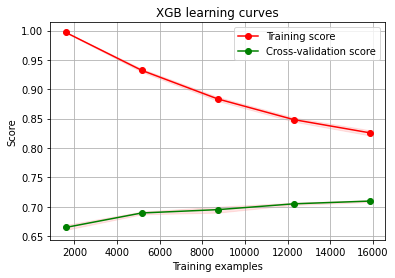

In [181]:
g = plot_learning_curve(xgb_clf, "XGB learning curves", X_train, y_train, cv=5)

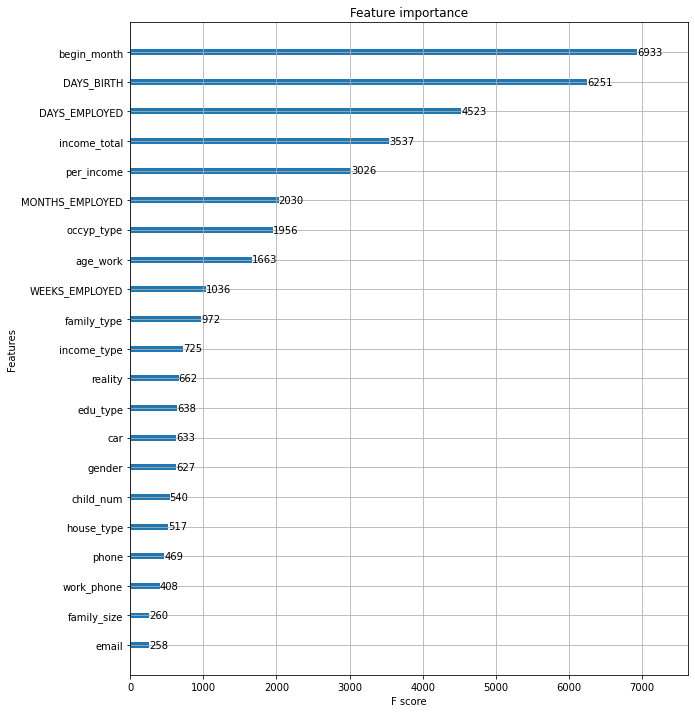

In [182]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_clf, ax=ax)
plt.show()

> **제출 파일 생성**

In [183]:
submission_xgb2 = pd.read_csv('/content/sample_submission.csv')
submission_xgb2.loc[:,1:] = xgb2_submission

In [185]:
submission_xgb2.to_csv('/content/sub_xgb2.csv', index=False)

### **4. CatBoost**

> **하이퍼 파라미터 설정을 하지 않은 모델의 성능이 가장 좋았음**

In [186]:
n_est = 2000
seed = 42
n_fold = 10
n_class = 3

train_x = train2.drop('credit', axis=1)
train_y = train2['credit']
test_x = test2

In [188]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds = []
for train_idx, valid_idx in skfold.split(train_x, train_y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((train_x.shape[0], n_class))
cat_pred_test = np.zeros((test_x.shape[0], n_class))
cat_cols = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']

for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = train_x.iloc[train_idx], train_x.iloc[valid_idx], train_y[train_idx], train_y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(test_x) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(train_y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.115044
0:	learn: 1.0346956	test: 1.0327132	best: 1.0327132 (0)	total: 108ms	remaining: 1m 47s
100:	learn: 0.7808265	test: 0.7866811	best: 0.7866811 (100)	total: 16s	remaining: 2m 22s
200:	learn: 0.7474524	test: 0.7723339	best: 0.7723339 (200)	total: 35.6s	remaining: 2m 21s
300:	learn: 0.7222567	test: 0.7631100	best: 0.7631100 (300)	total: 45.4s	remaining: 1m 45s
400:	learn: 0.6972145	test: 0.7531867	best: 0.7531867 (400)	total: 55.4s	remaining: 1m 22s
500:	learn: 0.6752118	test: 0.7467596	best: 0.7467568 (499)	total: 1m 5s	remaining: 1m 5s
600:	learn: 0.6543478	test: 0.7402205	best: 0.7402205 (600)	total: 1m 15s	remaining: 50.2s
700:	learn: 0.6335827	test: 0.7339282	best: 0.7339282 (700)	total: 1m 25s	remaining: 36.6s
800:	learn: 0.6149800	test: 0.7289862	best: 0.7289079 (798)	total: 1m 38s	remaining: 24.4s
900:	learn: 0.5994050	test: 0.7258058	best: 0.7257911 (899)	total: 1m 49s	remaining: 12s
999:	learn: 0.5858394	te

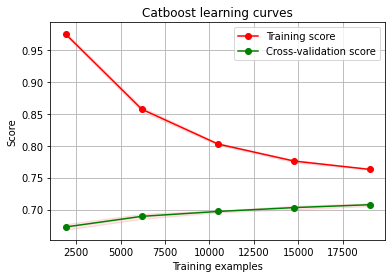

In [189]:
g = plot_learning_curve(model_cat,"Catboost learning curves", X_train, y_train, cv=5)

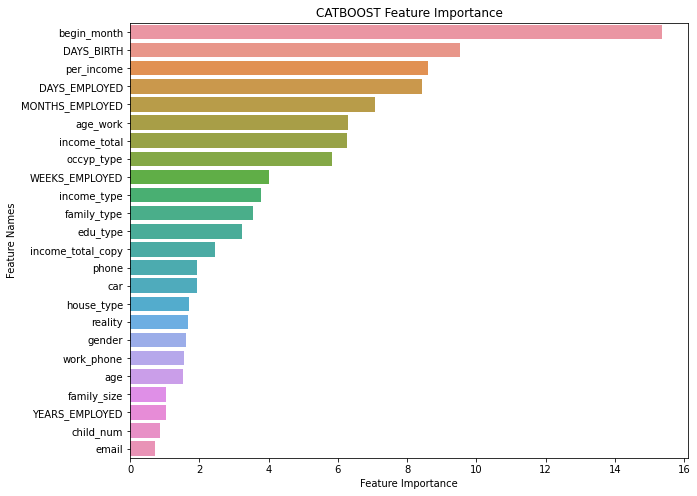

In [190]:
plot_feature_importance(model_cat.get_feature_importance(), test_x.columns, 'CATBOOST')

> **제출 파일 생성**

In [191]:
submission_catb2 = pd.read_csv('/content/sample_submission.csv')
submission_catb2.loc[:,1:] = cat_pred_test

In [192]:
submission_catb2.to_csv('/content/sub_catb2.csv', index=False)

### **3차 전처리 진행**
> **1차 모델링 이후, 모델의 성능 향상을 위해 변수를 추가하는 3차 전처리를 진행**

#### **1. 근무일 당 소득 변수 income_per_day 생성**

In [193]:
train['income_per_day'] = train['income_total_copy']//train['DAYS_EMPLOYED']
test['income_per_day'] = test['income_total_copy']//test['DAYS_EMPLOYED']

In [194]:
train['income_per_day'] = train['income_per_day'].map(lambda x: 0 if x == np.inf else x)
test['income_per_day']= test['income_per_day'].map(lambda x: 0 if x == np.inf else x)

#### **2. id 변수 생성**
> **한 사람이 카드를 여러 개 사용할 수 있음을 고려하여, 개인을 특정할 수 있는 ID 변수 생성**

> **Categorical Variable을 이용하여 변수 생성**

In [195]:
train['ID'] = \
train['gender'].astype(str) + '_' + train['DAYS_BIRTH'].astype(str) + '_' + train['car'].astype(str) + '_' + train['reality'].astype(str) + '_'+  \
train['income_type'].astype(str) + '_' + train['edu_type'].astype(str) + '_' + train['family_type'].astype(str) + '_' + train['house_type'].astype(str) +'_'+\
train['occyp_type'].astype(str) + '_' +  train['phone'].astype(str) + '_' + train['work_phone'].astype(str) + '_' + train['email'].astype(str) + '_' + \
train['child_num'].astype(str) + '_' + train['family_size'].astype(str)

In [196]:
test['ID'] = \
test['gender'].astype(str) + '_' + test['DAYS_BIRTH'].astype(str) + '_' + test['car'].astype(str) + '_' + test['reality'].astype(str) + '_' + \
test['income_type'].astype(str) + '_' + test['edu_type'].astype(str) + '_' + test['family_type'].astype(str) + '_' + test['house_type'].astype(str) +'_'+\
test['occyp_type'].astype(str) + '_' +  test['phone'].astype(str) + '_' + test['work_phone'].astype(str) + '_' + test['email'].astype(str) + '_' + \
test['child_num'].astype(str) + '_' +  test['family_size'].astype(str) 

In [197]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,credit,income_total_copy,YEARS_EMPLOYED,MONTHS_EMPLOYED,WEEKS_EMPLOYED,age,per_income,age_work,income_per_day,ID
0,F,N,N,0,12.218500,Commercial associate,Higher education,Married,Municipal apartment,13899,...,1.0,202500.0,12,0.0,0.0,38,11.53,26,43.0,F_13899_N_N_Commercial associate_Higher educat...
1,F,N,Y,1,12.419170,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,...,1.0,247500.0,4,3.0,0.0,31,11.32,27,160.0,F_11380_N_Y_Commercial associate_Secondary / s...
2,M,Y,Y,0,13.017005,Working,Higher education,Married,House / apartment,19087,...,2.0,450000.0,12,3.0,1.0,52,12.32,40,101.0,M_19087_Y_Y_Working_Higher education_Married_H...
3,F,N,Y,0,12.218500,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,...,0.0,202500.0,5,9.0,2.0,41,11.53,36,96.0,F_15088_N_Y_Commercial associate_Secondary / s...
4,F,Y,Y,0,11.967187,State servant,Higher education,Married,House / apartment,15037,...,2.0,157500.0,5,10.0,0.0,41,11.27,36,74.0,F_15037_Y_Y_State servant_Higher education_Mar...


In [198]:
train['ID'].value_counts()

F_15519_N_Y_Commercial associate_Secondary / secondary special_Single / not married_Rented apartment_Laborers_0_0_0_0_1.0          35
M_16768_N_N_Working_Higher education_Civil marriage_House / apartment_Laborers_0_1_0_2_4.0                                         24
F_12676_N_Y_State servant_Secondary / secondary special_Single / not married_House / apartment_Waiters/barmen staff_0_0_0_1_2.0    24
M_9952_Y_Y_Working_Secondary / secondary special_Single / not married_House / apartment_etc_0_0_0_0_1.0                            21
F_22976_N_Y_Pensioner_Secondary / secondary special_Single / not married_House / apartment_etc_0_0_0_0_1.0                         20
                                                                                                                                   ..
F_12277_N_N_State servant_Secondary / secondary special_Married_House / apartment_Laborers_1_1_0_4_6.0                              1
F_18029_Y_Y_Working_Secondary / secondary special_Single / not

In [199]:
train['ID'].isnull().sum()

0

#### **3. 범주형 변수 라벨 인코딩**

> **모델 학습을 위해 범주형 변수에 대해 라벨 인코딩을 진행**

In [201]:
train['gender'] = train['gender'].replace(['F','M'], [0,1])
test['gender'] = test['gender'].replace(['F','M'], [0,1])

train['car'] = train['car'].replace(['N','Y'], [0,1])
test['car'] = test['car'].replace(['N','Y'], [0,1])

train['reality'] = train['reality'].replace(['N','Y'], [0,1])
test['reality'] = test['reality'].replace(['N','Y'], [0,1])

In [202]:
train.dtypes

gender                 int64
car                    int64
reality                int64
child_num              int64
income_total         float64
income_type           object
edu_type              object
family_type           object
house_type            object
DAYS_BIRTH             int64
DAYS_EMPLOYED          int64
work_phone             int64
phone                  int64
email                  int64
occyp_type            object
family_size          float64
begin_month          float64
credit               float64
income_total_copy    float64
YEARS_EMPLOYED         int64
MONTHS_EMPLOYED      float64
WEEKS_EMPLOYED       float64
age                    int64
per_income           float64
age_work               int64
income_per_day       float64
ID                    object
dtype: object

In [203]:
from category_encoders.ordinal import OrdinalEncoder

cate_list = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

encoder = OrdinalEncoder(cate_list)
train[cate_list] = encoder.fit_transform(train[cate_list])
test[cate_list] = encoder.fit_transform(test[cate_list])

> **object형 변수 사라짐**

In [204]:
train.dtypes

gender                 int64
car                    int64
reality                int64
child_num              int64
income_total         float64
income_type            int64
edu_type               int64
family_type            int64
house_type             int64
DAYS_BIRTH             int64
DAYS_EMPLOYED          int64
work_phone             int64
phone                  int64
email                  int64
occyp_type             int64
family_size          float64
begin_month          float64
credit               float64
income_total_copy    float64
YEARS_EMPLOYED         int64
MONTHS_EMPLOYED      float64
WEEKS_EMPLOYED       float64
age                    int64
per_income           float64
age_work               int64
income_per_day       float64
ID                     int64
dtype: object

In [205]:
train['ID'].value_counts()

131     35
386     24
728     24
1493    21
1379    20
        ..
5655     1
5656     1
5657     1
5659     1
8748     1
Name: ID, Length: 8748, dtype: int64

In [206]:
for col in ['reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']:
  train[col] = train[col].astype('int64')
  test[col] = test[col].astype('int64')

In [213]:
train['credit'] = train['credit'].astype('int64')

In [214]:
train.dtypes

gender               int64
car                  int64
reality              int64
child_num            int64
income_total       float64
income_type          int64
edu_type             int64
family_type          int64
house_type           int64
work_phone           int64
phone                int64
email                int64
occyp_type           int64
begin_month        float64
credit               int64
YEARS_EMPLOYED       int64
MONTHS_EMPLOYED    float64
WEEKS_EMPLOYED     float64
age                  int64
per_income         float64
age_work             int64
income_per_day     float64
ID                   int64
dtype: object

#### **4. 수치형 변수 스케일링**


> **숫자가 너무 커서 스케일링 안되는 문제 해결**

In [207]:
train['per_income'] = round(train['per_income'], 2) 
test['per_income'] = round(test['per_income'], 2)

In [215]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,work_phone,...,begin_month,credit,YEARS_EMPLOYED,MONTHS_EMPLOYED,WEEKS_EMPLOYED,age,per_income,age_work,income_per_day,ID
0,0,0,0,0,12.218500,1,1,1,1,0,...,-1.215231,1,12,0.0,0.0,38,0.332398,26,-0.378512,1
1,0,0,1,1,12.419170,1,2,2,2,0,...,-1.275620,1,4,3.0,0.0,31,-0.000263,27,-0.017509,2
2,1,1,1,0,13.017005,2,1,1,2,0,...,-0.249003,2,12,3.0,1.0,52,1.583836,40,-0.199554,3
3,0,0,1,0,12.218500,1,2,1,2,0,...,0.656836,0,5,9.0,2.0,41,0.332398,36,-0.214981,4
4,0,1,1,0,11.967187,3,1,1,2,0,...,-0.007446,2,5,10.0,0.0,41,-0.079468,36,-0.282862,5


> **수치형 변수를 스케일링**

In [209]:
numeric_list = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'per_income', 'income_per_day']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train[numeric_list] = scaler.fit_transform(train[numeric_list])
test[numeric_list] = scaler.transform(test[numeric_list])

####  **5. 다중 공선성이 높은 변수 및 피처 중요도가 낮은 피처 제거**
> **family_size, DAYS_BIRTH, DAYS_EMPLOYED 피처를 제거**

> **파생 변수를 만들기 위해 복사했던 income_total_copy 피처를 제거**

In [210]:
train.drop(['family_size', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'income_total_copy'], axis=1, inplace=True)
test.drop(['family_size', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'income_total_copy'], axis=1, inplace=True)

### **최종 피처 확인**

In [211]:
train.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'work_phone', 'phone', 'email',
       'occyp_type', 'begin_month', 'credit', 'YEARS_EMPLOYED',
       'MONTHS_EMPLOYED', 'WEEKS_EMPLOYED', 'age', 'per_income', 'age_work',
       'income_per_day', 'ID'],
      dtype='object')

In [212]:
test.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'work_phone', 'phone', 'email',
       'occyp_type', 'begin_month', 'YEARS_EMPLOYED', 'MONTHS_EMPLOYED',
       'WEEKS_EMPLOYED', 'age', 'per_income', 'age_work', 'income_per_day',
       'ID'],
      dtype='object')

### **3차 전처리 후 최종 데이터셋 저장**

In [216]:
train.to_csv('/content/train_after3.csv', index=False)
test.to_csv('/content/test_after3.csv', index=False)

### **2차 모델링**
> **1차 모델링과 같은 하이퍼 파라미터를 가진 모델에 학습과 예측을 진행**

> **모델 학습 전 데이터 분할**

In [217]:
train_x = train.drop('credit', axis=1)
train_y = train['credit']
test_x = test

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.25, random_state=100)

### **1. LGBM**

> **앞서 구한 최적 하이퍼 파라미터로 모델 학습과 예측**

In [218]:
lgbm_clf = LGBMClassifier(n_estimators=200, learning_rate=0.05, num_iterations=50,  max_depth=12, num_leaves=64, min_child_samples=60, subsample=0.8)

In [219]:
lgbm3_submission = run_kfold(lgbm_clf)

FOLD 0 : logloss:0.7791747818900604
FOLD 1 : logloss:0.7735789128855299
FOLD 2 : logloss:0.7806026055251318
FOLD 3 : logloss:0.7768456616884901
FOLD 4 : logloss:0.7743673077097907
Mean:0.7769138539398006


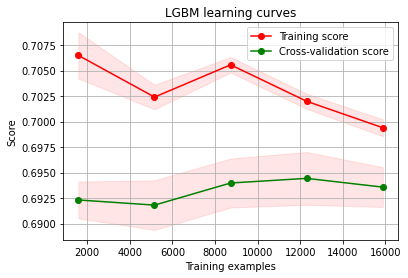

In [220]:
g = plot_learning_curve(lgbm_clf, "LGBM learning curves", X_train, y_train, cv=5)

> **제출 파일 생성**

In [221]:
submission_lgbm3 = pd.read_csv('/content/sample_submission.csv')
submission_lgbm3.loc[:,1:] = lgbm3_submission

In [222]:
submission_lgbm3.to_csv('/content/sub_lgbm3.csv', index=False)

### **2. Random Forest**

> **앞서 구한 최적 하이퍼 파라미터로 모델 학습과 예측**

In [223]:
rnd_clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=12, min_samples_leaf=8, min_samples_split=8)

In [224]:
rnd3_submission = run_kfold(rnd_clf)

FOLD 0 : logloss:0.7740937038691881
FOLD 1 : logloss:0.7695817648501253
FOLD 2 : logloss:0.7710335230962841
FOLD 3 : logloss:0.7690129469871714
FOLD 4 : logloss:0.7683862842763648
Mean:0.7704216446158267


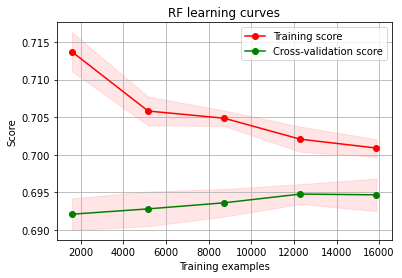

In [225]:
g = plot_learning_curve(rnd_clf, "RF learning curves", X_train, y_train, cv=5)

> **제출 파일 생성**

In [226]:
submission_rnd3 = pd.read_csv('/content/sample_submission.csv')
submission_rnd3.loc[:,1:] = rnd3_submission

In [227]:
submission_rnd3.to_csv('/content/sub_rnd3.csv', index=False)

### **3. XGBoost**

> **앞서 구한 최적 하이퍼 파라미터로 모델 학습과 예측**

In [228]:
xgb_clf = XGBClassifier(learning_rate=0.15, max_depth=10, n_estimators=70)

In [229]:
xgb3_submission = run_kfold(xgb_clf)

FOLD 0 : logloss:0.731157877118533
FOLD 1 : logloss:0.7233586206325441
FOLD 2 : logloss:0.7319092328386126
FOLD 3 : logloss:0.717114694635492
FOLD 4 : logloss:0.7232699169138557
Mean:0.7253620684278075


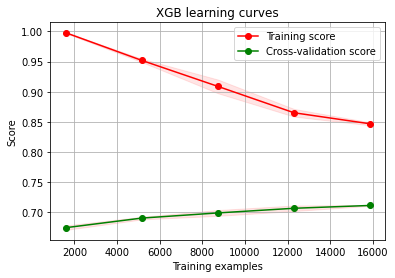

In [230]:
g = plot_learning_curve(xgb_clf, "XGB learning curves", X_train, y_train, cv=5)

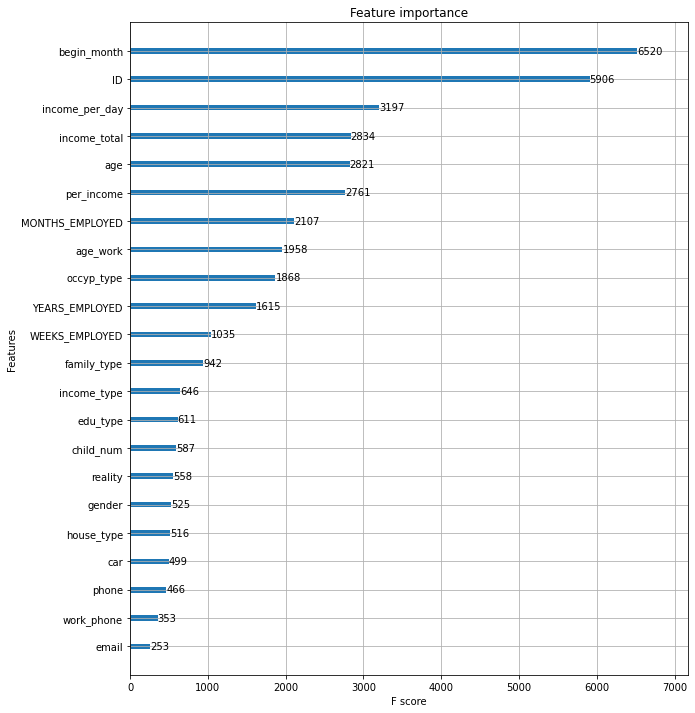

In [231]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_clf, ax=ax)
plt.show()

> **제출 파일 생성**

In [232]:
submission_xgb3 = pd.read_csv('/content/sample_submission.csv')
submission_xgb3.loc[:,1:] = xgb3_submission

In [233]:
submission_xgb3.to_csv('/content/sub_xgb3.csv', index=False)

### **4. CatBoost**

> **하이퍼 파라미터 설정을 하지 않은 모델의 성능이 가장 좋았음**

In [234]:
n_est = 2000
seed = 42
n_fold = 10
n_class = 3

train_x = train.drop('credit', axis=1)
train_y = train['credit']
test_x = test

In [235]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds = []
for train_idx, valid_idx in skfold.split(train_x, train_y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((train_x.shape[0], n_class))
cat_pred_test = np.zeros((test_x.shape[0], n_class))
cat_cols = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']

for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = train_x.iloc[train_idx], train_x.iloc[valid_idx], train_y[train_idx], train_y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(test_x) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(train_y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.115044
0:	learn: 1.0360039	test: 1.0342036	best: 1.0342036 (0)	total: 141ms	remaining: 2m 21s
100:	learn: 0.7823217	test: 0.7860411	best: 0.7860411 (100)	total: 8.94s	remaining: 1m 19s
200:	learn: 0.7443255	test: 0.7681725	best: 0.7681725 (200)	total: 21.3s	remaining: 1m 24s
300:	learn: 0.7139902	test: 0.7563904	best: 0.7563904 (300)	total: 31s	remaining: 1m 12s
400:	learn: 0.6857579	test: 0.7473088	best: 0.7473088 (400)	total: 41s	remaining: 1m 1s
500:	learn: 0.6622366	test: 0.7393953	best: 0.7392501 (498)	total: 50.9s	remaining: 50.7s
600:	learn: 0.6410326	test: 0.7330862	best: 0.7330862 (600)	total: 1m	remaining: 40.4s
700:	learn: 0.6214323	test: 0.7276229	best: 0.7276229 (700)	total: 1m 10s	remaining: 30.3s
800:	learn: 0.6032160	test: 0.7235299	best: 0.7234793 (795)	total: 1m 20s	remaining: 20.1s
900:	learn: 0.5854117	test: 0.7194512	best: 0.7194512 (900)	total: 1m 30s	remaining: 9.99s
999:	learn: 0.5691571	test: 0

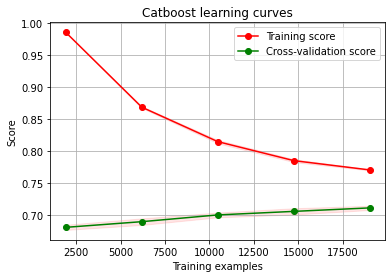

In [236]:
g = plot_learning_curve(model_cat,"Catboost learning curves", X_train, y_train, cv=5)

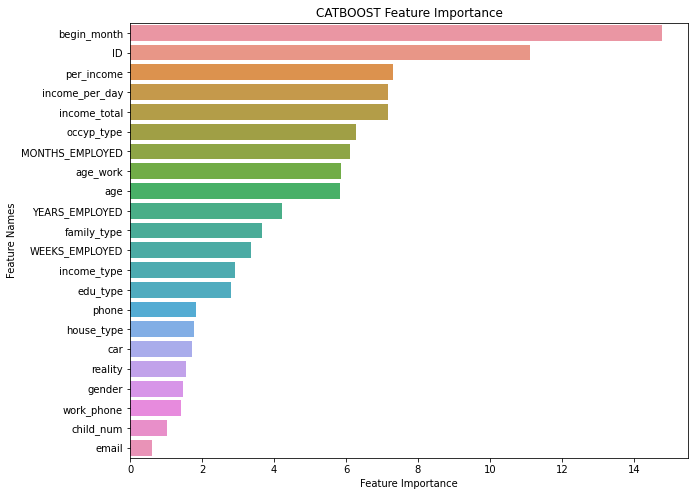

In [237]:
plot_feature_importance(model_cat.get_feature_importance(), test_x.columns, 'CATBOOST')

> **제출 파일 생성**

In [238]:
submission_catb3 = pd.read_csv('/content/sample_submission.csv')
submission_catb3.loc[:,1:] = cat_pred_test

In [239]:
submission_catb3.to_csv('/content/sub_catb3.csv', index=False)